In [1]:
import pandas as pd
df=pd.read_csv('SurveyData.csv', sep=';')

In [2]:
df.columns

Index(['Response ID', 'Date submitted', 'Last page', 'Start language', 'Seed',
       'Date started', 'Date last action',
       'How many conferences (+papers published in journals) did you attend in the last 5 years (approximately) ?',
       'What is your CSCL context (task and public: e.g. language learning in K12)',
       'For how many years have you been involved in CSCL as a researcher?',
       'What is your position?', 'If you selected "other", please specify:',
       'What is your native language?', 'What is your country of origin?',
       'What is your gender?', 'What is your age?',
       'How do you define Computer Supported Collaborative Learning (CSCL) in one sentence?',
       'Please indicate your agreement with the following definitions of Computer Supported Collaborative Learning (CSCL). [CSCL is the process of collaborative learning with technology]',
       'Please indicate your agreement with the following definitions of Computer Supported Collaborative Learnin

In [3]:
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

# Function to preprocess text by removing common starting phrases
def preprocess_text(text, phrases_to_remove=None):
    if phrases_to_remove is None:
        phrases_to_remove = ["CSCL is", 
                             "Computer Supported Collaborative Learning (CSCL) is",
                             "CL is",
                             "Collaborative Learning is"]
    for phrase in phrases_to_remove:
        text = re.sub(f"^{phrase}", "", text, flags=re.IGNORECASE).strip()
    return text

# Function to embed text data after preprocessing
def get_text_embeddings(df, column_filter, model_name='all-MiniLM-L6-v2'):
    text_columns = [c for c in df.columns if column_filter in c]
    text_data = df[text_columns].fillna('').astype(str).apply(lambda row: ' '.join(row), axis=1)
    text_data = text_data.apply(preprocess_text)  # Apply preprocessing to each text entry

    model = SentenceTransformer(model_name)
    embeddings = model.encode(text_data.tolist(), show_progress_bar=True)
    
    return text_columns, embeddings

# Function to plot the elbow curve to determine optimal number of clusters
def plot_elbow_curve(embeddings, max_clusters=10):
    inertia = []
    cluster_range = range(1, max_clusters + 1)
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(embeddings)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, inertia, marker='o')
    plt.title('Elbow Curve for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.show()

# Function to cluster and visualize based on selected number of clusters
def cluster_and_visualize(df, embeddings, text_columns, n_clusters):
    # Perform KMeans with selected number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(embeddings)

    # Reduce embeddings to 2D using PCA for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(embeddings_2d, columns=['PC1', 'PC2'])
    plot_df['cluster'] = df['cluster']

    # Visualize the clusters
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=plot_df, s=100, alpha=0.7)
    plt.title(f'KMeans Clustering with {n_clusters} Clusters')
    plt.show()

    # Display the text responses grouped by cluster
    for cluster_num in range(n_clusters):
        print(f"\n--- Texts in Cluster {cluster_num} ---")
        cluster_texts = df[text_columns][df['cluster'] == cluster_num].apply(lambda row: ' '.join(row), axis=1)
        for idx, text in enumerate(cluster_texts):
            print(f"{idx + 1}. {text}")

# Main function to execute the entire process with any input column filter
def analyze_text_clusters(df, column_filter, max_clusters=10):
    text_columns, embeddings = get_text_embeddings(df, column_filter)
    
    # Plot the elbow curve
    plot_elbow_curve(embeddings, max_clusters)

    # Interactive clustering visualization
    interact(lambda n_clusters: cluster_and_visualize(df, embeddings, text_columns, n_clusters), n_clusters=(2, max_clusters))

# Function to analyze text embeddings and plot the elbow curve
def analyze_text_embeddings(df, column_filter, max_clusters=10):
    # Generate embeddings based on the input column filter
    text_columns, embeddings = get_text_embeddings(df, column_filter)
    
    # Show the elbow plot
    print("Generating elbow plot to determine optimal number of clusters...")
    plot_elbow_curve(embeddings, max_clusters)
    
    # Return embeddings and text columns for further analysis
    return embeddings, text_columns

# Function for clustering and visualization based on a selected number of clusters
def interactive_clustering(df, embeddings, text_columns, max_clusters=10):
    print("Select the number of clusters for visualization:")
    interact(lambda n_clusters: cluster_and_visualize(df, embeddings, text_columns, n_clusters), n_clusters=(2, max_clusters))

In [4]:
from sklearn.metrics import silhouette_score


In [5]:
def plot_silhouette_scores(embeddings, max_clusters=10):
    silhouette_scores = []
    cluster_range = range(2, max_clusters + 1)
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, silhouette_scores, marker='o', color='b')
    plt.title('Silhouette Score for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.show()


In [6]:
# Main function to execute the analysis and plot both the elbow and silhouette curves
def analyze_text_clusters_with_silhouette(df, column_filter, max_clusters=10):
    text_columns, embeddings = get_text_embeddings(df, column_filter)
    
    # Plot the elbow curve for inertia
    print("Elbow plot for cluster inertia:")
    plot_elbow_curve(embeddings, max_clusters)

    input('continue?')
    
    # Plot silhouette scores
    print("Silhouette scores for optimal cluster selection:")
    plot_silhouette_scores(embeddings, max_clusters)

    nn = int(input('how many clusters?'))
    
    # Interactive clustering visualization
    print("Select the number of clusters for visualization:")
    interact(lambda n_clusters: cluster_and_visualize(df, embeddings, text_columns, n_clusters), n_clusters=nn)

## CSCL definition simple and complex

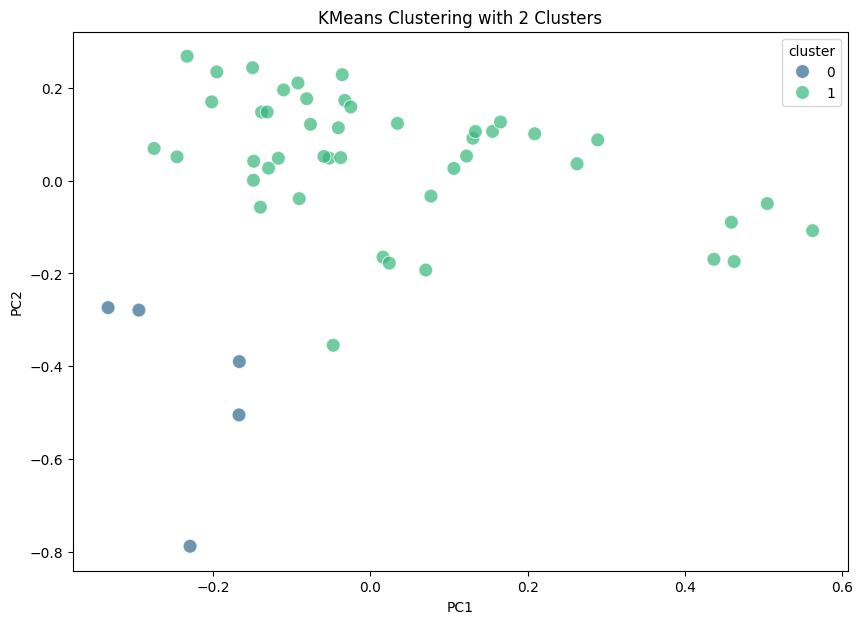


--- Texts in Cluster 0 ---
1. faciliter la collaboration dans l'apprentissage et l'apprentissage de la collaboration par les technologies num�riques
2. Shared co-construction of knowledge
3. Le pr�sent et le futur
4. CSCL is a process of constructing a shared meaning within a technology enhanced environment by a group of human and/or technological agents.
5. Co-creation of knowledge in online environments

--- Texts in Cluster 1 ---
1. Leveraging technological tools and practices to facilitate/ support collaborative learning processes and outcomes
2. Activities that involve a laptop, iPad, phone, phone app to practice writing, reading, listening or speaking skills with other learners of language
3. Learning of or through collaboration in a digital setting
4. Collaborative learning happens when learners interact with the goal of developing their competencies (= learning goal) and thereby referring to each others contributions while adding a novel aspect to it (= transactivity). Collabo

interactive(children=(IntSlider(value=2, description='n_clusters', max=6, min=-2), Output()), _dom_classes=('w…

In [7]:
# Example usage
s = 'How do you define Computer Supported Collaborative Learning (CSCL) in one sentence?'

# Call the function with silhouette analysis
analyze_text_clusters_with_silhouette(df, s, max_clusters=20)

Summary of Cluster 0
This cluster centers on the concept of collaborative knowledge-building in digital environments. It discusses the shared construction and co-creation of knowledge, emphasizing collaboration through digital means and the importance of collective understanding in technology-enhanced learning.

Summary of Cluster 1
This cluster provides an in-depth exploration of Computer-Supported Collaborative Learning (CSCL) as both a research field and pedagogical approach. It highlights the use of digital tools to facilitate group learning, focusing on social interactions, knowledge construction, and collaboration among students mediated by computers or technology. The texts also discuss various methodologies, educational frameworks (like socio-constructivism), and the role of technology in enhancing communication and support for group-based learning outcomes.

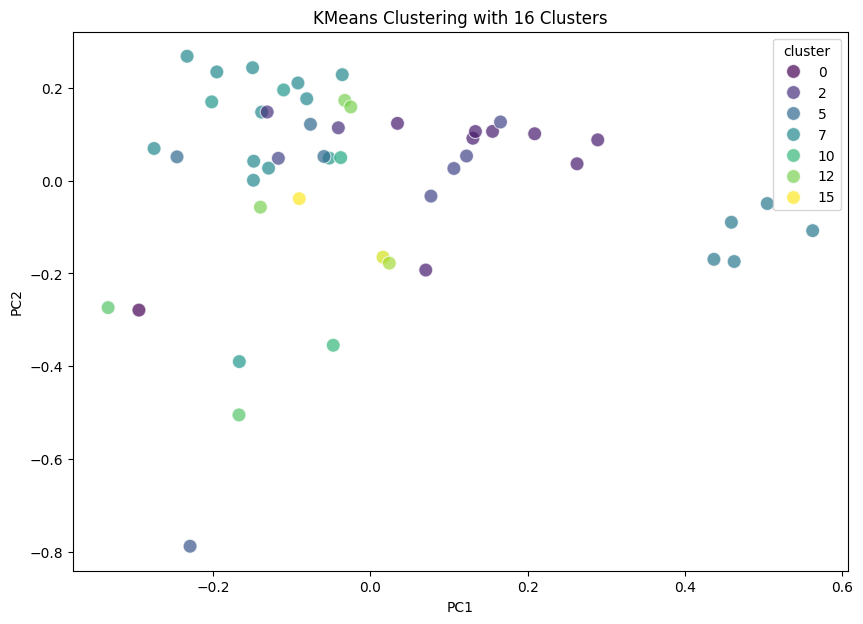


--- Texts in Cluster 0 ---
1. CSCL is a process of constructing a shared meaning within a technology enhanced environment by a group of human and/or technological agents.

--- Texts in Cluster 1 ---
1. Leveraging technological tools and practices to facilitate/ support collaborative learning processes and outcomes
2. Collaborative learning happens when learners interact with the goal of developing their competencies (= learning goal) and thereby referring to each others contributions while adding a novel aspect to it (= transactivity). Collaborative learning is computer-supported when this interaction is mediated or augmented or guided or scaffolded by digital technology.
3. Models or tools that help students to engage a collaborative learning
4. To be honest, it�s hard for me to define, considering in my opinion, most learning nowadays satisfies the definition of computer-supported and collaborative.
5. Study of tools and technologies to enhance collaborative learning
6. Methods for 

interactive(children=(IntSlider(value=16, description='n_clusters', max=48, min=-16), Output()), _dom_classes=…

In [8]:
# Example usage
s = 'How do you define Computer Supported Collaborative Learning (CSCL) in one sentence?'

# Call the function with silhouette analysis
analyze_text_clusters_with_silhouette(df, s, max_clusters=20)

Cluster 0:
Defines CSCL as a collaborative process where a group (human or technological) co-constructs knowledge in a digitally enhanced environment.

Cluster 1:
Focuses on leveraging digital tools to facilitate collaborative learning, emphasizing both the development of competencies and transactive interactions among students, supported by technology.

Cluster 2:
Describes CSCL as a method for learning collaboratively through online communication, emphasizing the computer or Internet as the medium.

Cluster 3:
Explores how technology supports group knowledge-building through collaboration, where students utilize shared expertise to reach a common learning goal in a technology-assisted environment.

Cluster 4:
Mentions "the present and the future" without further context.

Cluster 5:
Describes technology-mediated group learning, including both synchronous and asynchronous formats that support interaction and regulation.

Cluster 6:
Positions CSCL as a pedagogical approach and research field focused on digital tools that support collaborative group learning and peer interactions, employing empirical methods for process understanding.

Cluster 7:
Discusses CSCL as a multi-disciplinary field that examines social and individual interactions in digital learning environments, guided by frameworks like socio-constructivism and exploring collaborative technology design.

Cluster 8:
Broadly defines CSCL as a research field on learning and collaboration supported by digital technology, focusing on collaborative learning design and analysis in educational contexts.

Cluster 9:
Simple statement on using technology to enable collaborative group learning.

Cluster 10:
A brief statement about a tool’s utility in facilitating sharing practices.

Cluster 11:
Describes the co-construction of knowledge in online environments, emphasizing shared, collaborative knowledge-building.

Cluster 12:
Highlights the role of digital tools in supporting group learning, with CSCL as both a pedagogical approach and a domain for research.

Cluster 13:
Briefly describes two or more people collaborating to exchange knowledge with computer support.

Cluster 14:
Focuses on tools that help learners interpret their unique learning processes.

Cluster 15:
Describes collaborative language practice activities using digital devices (laptops, phones, etc.), emphasizing language skills development.

## CL Definition east and complex

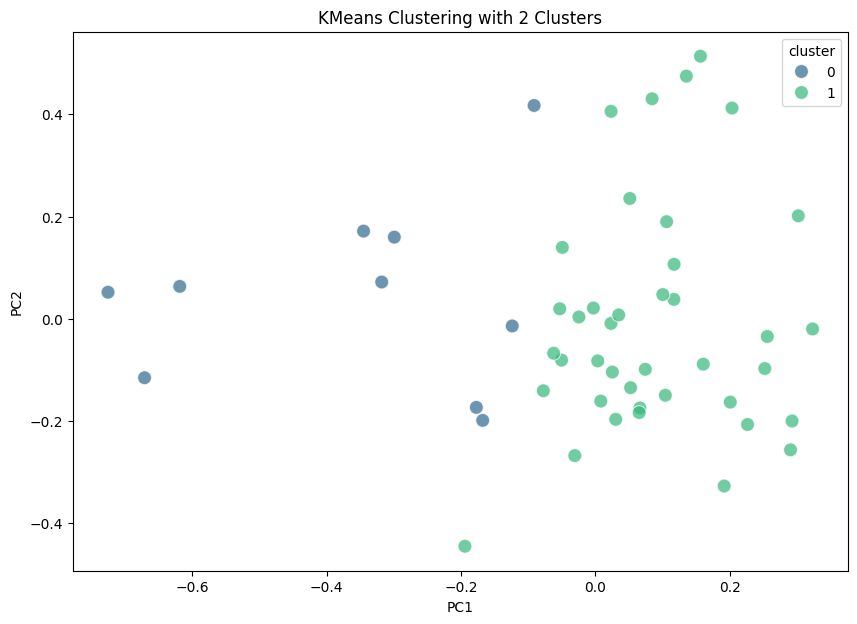


--- Texts in Cluster 0 ---
1. The process and outcomes of people engaging in a shared activity synchronously or asynchronously
2. Please copy my previous answer without the second sentence.
3. Learners building their understanding through communication that is either moderated through technology or the technology is present as an observer.
4. sequence d'apprentissage lors de laquelle les eleves sont impliqu�es dans une action conjointe et partagent une vision commune des taches et de problemes souleves
5. As the cell learns, coll. learning is about imitations: students are learning from each other, including the professor.
6. L�apprentissage assist� par l�ordinateur
7. CL is a process of constructing a shared understanding by a a group of human/technological agents.
8. Collaborative learning is an approach in which participants work together on tasks, often in small groups.
9. An interactive process aimed at multiple participants to modify durably their representations or behaviors.
1

interactive(children=(IntSlider(value=2, description='n_clusters', max=6, min=-2), Output()), _dom_classes=('w…

In [9]:
s = 'ow do you define Collaborative Learning (CL) in CSCL in one sentence?'

# Call the function with silhouette analysis
analyze_text_clusters_with_silhouette(df, s, max_clusters=20)

Cluster 0:
Describes collaborative learning as a shared activity where participants work together—synchronously or asynchronously—to build understanding or solve tasks. The cluster highlights mutual learning through communication, shared goals, and interactions, with technology often facilitating or observing the process.

Cluster 1:
Focuses on collaborative learning as a process of co-constructing knowledge through social interactions and peer support. It emphasizes the active role of each learner in achieving common goals, sharing knowledge, and helping one another within a structured, participatory environment. This cluster also distinguishes collaboration from cooperation by underscoring shared understanding and joint agency in achieving learning objectives.

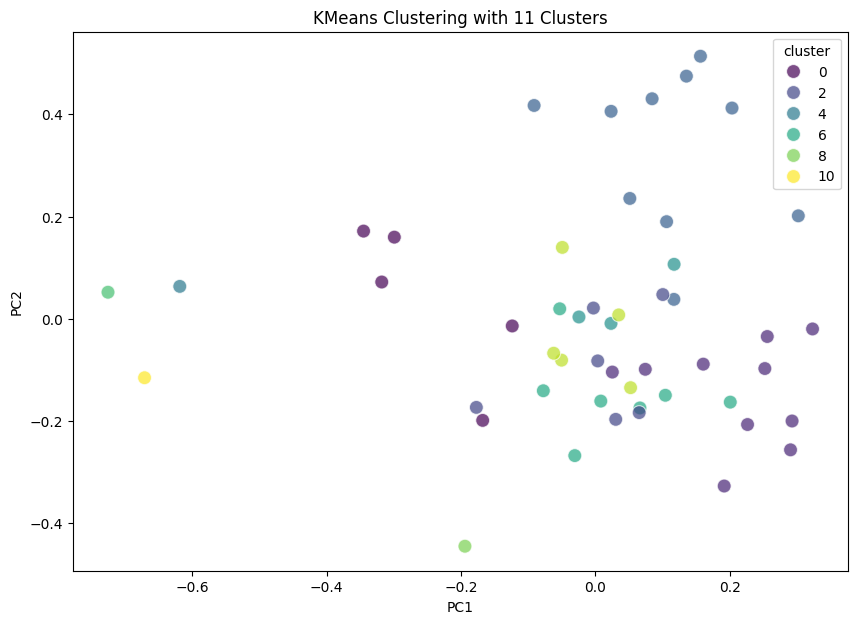


--- Texts in Cluster 0 ---
1. The process and outcomes of people engaging in a shared activity synchronously or asynchronously
2. Learners building their understanding through communication that is either moderated through technology or the technology is present as an observer.
3. CL is a process of constructing a shared understanding by a a group of human/technological agents.
4. An interactive process aimed at multiple participants to modify durably their representations or behaviors.
5. Two or more people trying to acquire or exchange information.

--- Texts in Cluster 1 ---
1. Collaborative learning engages peers to contribute knowledge and participate actively to achieve a common goal or project.
2. Collaborative learning is characterized by the importance of social interactions and peer support relationships. Combining each other's knowledge and co-constructing without conflict characterize collaborative learning.
3. It depends on the epistemological point of view that you decid

interactive(children=(IntSlider(value=11, description='n_clusters', max=33, min=-11), Output()), _dom_classes=…

In [10]:
s = 'ow do you define Collaborative Learning (CL) in CSCL in one sentence?'

# Call the function with silhouette analysis
analyze_text_clusters_with_silhouette(df, s, max_clusters=20)

Cluster 0:
Describes collaborative learning as a joint, interactive process where participants build shared understanding, often aided by technology. It emphasizes both synchronous and asynchronous communication for acquiring or exchanging information in group contexts.

Cluster 1:
Focuses on collaborative learning as an active, social process where peers support each other to reach common goals, combining knowledge without conflict. It includes perspectives on co-construction and shared understanding in technology-mediated environments.

Cluster 2:
Highlights learning through mutual support and synergy, emphasizing interpersonal learning in group settings where peers help each other to achieve learning outcomes.

Cluster 3:
Describes collaborative learning in structured small groups, where participants work toward shared academic objectives, using each other’s expertise to complete tasks, often with technology support.

Cluster 4:
Mentions "computer-assisted learning" without further elaboration.

Cluster 5:
Explores collaborative learning strategies where peers support each other to improve individual learning through active engagement with instructors and classmates.

Cluster 6:
Focuses on collaboration as a process of co-constructing knowledge through active, transactive interactions involving cognitive and metacognitive activities, benefiting all group members.

Cluster 7:
Defines collaborative learning as a shared activity where students engage in joint tasks and develop a common understanding of issues and problems.

Cluster 8:
Briefly highlights the co-construction of new knowledge in collaborative settings.

Cluster 9:
Describes collaborative learning as engaging in tasks and making meaning together with shared goals and missions, underscoring mutual elaboration and goal alignment.

Cluster 10:
A request to repeat a previous answer with modifications, lacking substantive content.

## Coop vs. collab

In [11]:
df['this_new'] = df['If you answered "Yes" in the previous question, how so?'].map(str) + df['If you answered "No" in the previous section, why?'].map(str)

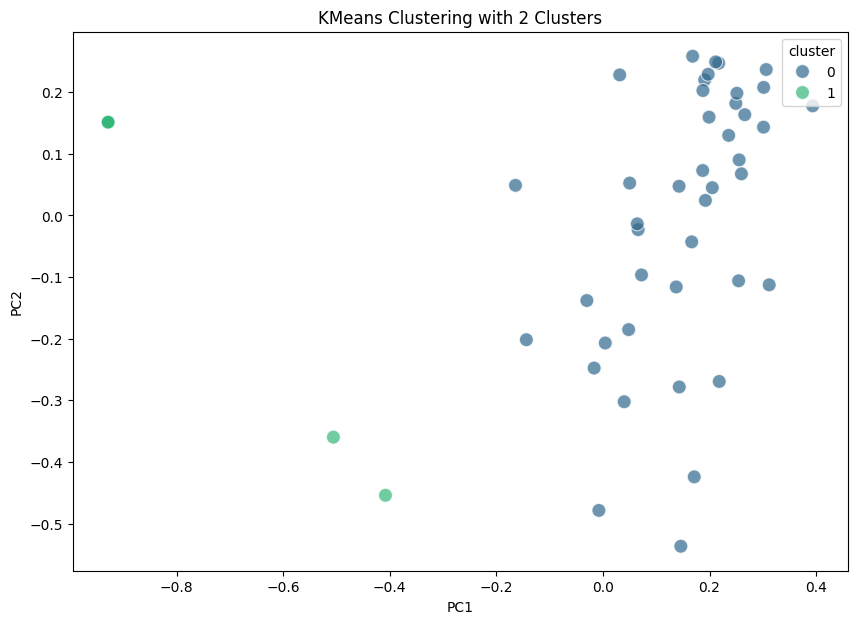


--- Texts in Cluster 0 ---
1. Collaborative learning to me is more comprehensive. Cooperative learning is subsection of it where partners take certain roles and responsibilities to accomplish a shared goal.nan
2. The First can only be done together  The latter facilitates learning of an individual but could also be done alonenan
3. Collaborative learning is a special case of cooperative learning. Cooperative learning simply means that students are assigned to groups and shall accomplish something as a group. That does not necessarily imply that they co-construct knowledge together. For instance, they simply can act according to the priniciple "divide and conquer", that is, they distribute different parts of the task among the group members, and, subsequently, each member is working on their own on each task part. I would reserve the term collaborative learning for instances of cooperative learning when students really refer to each others contributions and build on them.nan
4. Collabo

interactive(children=(IntSlider(value=2, description='n_clusters', max=6, min=-2), Output()), _dom_classes=('w…

In [12]:
s = 'this_new'

# Call the function with silhouette analysis
analyze_text_clusters_with_silhouette(df, s, max_clusters=20)

Cluster 0:
This cluster elaborates on the nuanced distinctions between collaborative and cooperative learning. Collaborative learning emphasizes joint work, shared understanding, and interdependence, where students actively engage and construct meaning together. In contrast, cooperative learning often involves dividing tasks among members who work independently on their assigned parts, with a focus on achieving a collective goal without necessarily co-constructing knowledge. Key points include role differentiation, levels of interdependence, and theoretical perspectives, with collaboration seen as more integrative and cooperation as more task-oriented.

Cluster 1:
Contains minimal substantive content, with entries indicating uncertainty, lack of distinction, or language barriers regarding the differentiation between collaboration and cooperation. Most responses express either indecision or irrelevance to the respondent’s research focus.

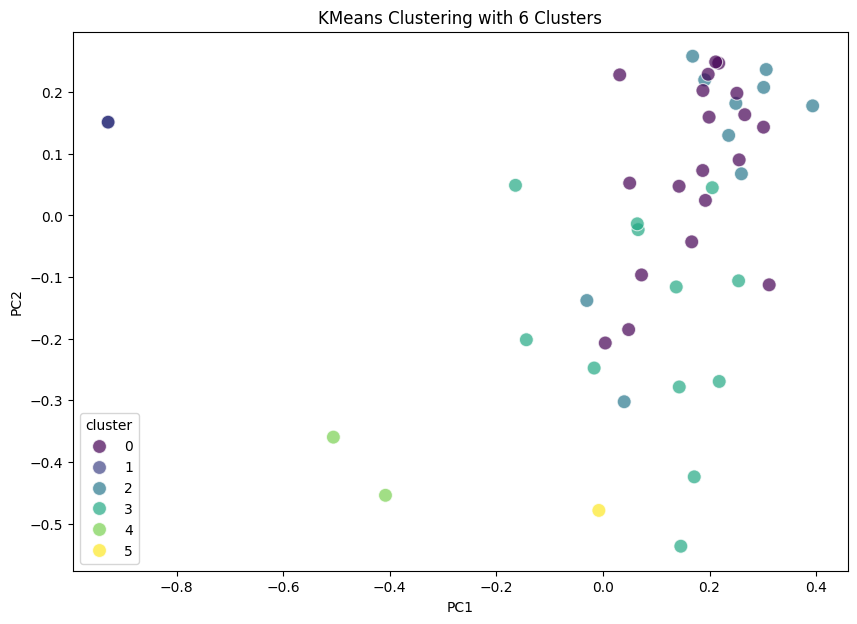


--- Texts in Cluster 0 ---
1. Collaborative learning to me is more comprehensive. Cooperative learning is subsection of it where partners take certain roles and responsibilities to accomplish a shared goal.nan
2. The First can only be done together  The latter facilitates learning of an individual but could also be done alonenan
3. Collaboration happens when leaners are working on the same part of the task, while cooperative learning happens when learners although coordinated, they are working on different part of the same task.nan
4. Cooperative means split work in tasks and sharing the tasking between the members of the group. Collaborative it's working together on the same task but with a particular profile than help the other to resolve a tasknan
5. As explained before: One describes individual learning through task division of e.g. a problem solving task but little exchange with peers needed, whereas the exchange with peers is at the center of the learning process and experience 

interactive(children=(IntSlider(value=6, description='n_clusters', max=18, min=-6), Output()), _dom_classes=('…

In [13]:
s = 'this_new'

# Call the function with silhouette analysis
analyze_text_clusters_with_silhouette(df, s, max_clusters=20)

Cluster 0:
Focuses on the distinction between collaborative and cooperative learning, with collaboration viewed as a comprehensive, integrative process where participants work together on the same task, actively negotiating shared meaning and knowledge. Cooperative learning, by contrast, involves task division where members work independently on assigned parts to achieve a shared goal, with less interdependence. This cluster highlights differences in structure, interdependence, and the nature of shared responsibility between the two forms of learning.

Cluster 1:
Consists of brief statements without substantial information, primarily placeholder or minimal content with repeated "nan" entries.

Cluster 2:
Explores collaborative and cooperative learning as distinct educational frameworks, where collaborative learning emphasizes shared understanding and joint problem-solving, often facilitated by peer interactions and group discussions. Cooperative learning focuses more on individual roles within a structured group setting, emphasizing accountability for assigned parts and mutual success. This cluster also contrasts sociocultural and cognitive perspectives in collaborative and cooperative learning research.

Cluster 3:
Discusses theoretical perspectives on collaboration versus cooperation, presenting collaboration as involving joint effort and interdependent tasks, while cooperation allows for more independent roles and task distribution. It explores collaboration as a continuum, where collaboration has a higher degree of coordination, engagement, and agency, while cooperation may require less communication and coordination among participants.

Cluster 4:
Contains reflections indicating personal uncertainty or lack of differentiation between collaboration and cooperation, often due to language or research focus.

Cluster 5:
Defines cooperation as a broader group learning scenario where participants may either assist each other or divide tasks, suggesting various group learning approaches with a focus on mutual support.

## Future

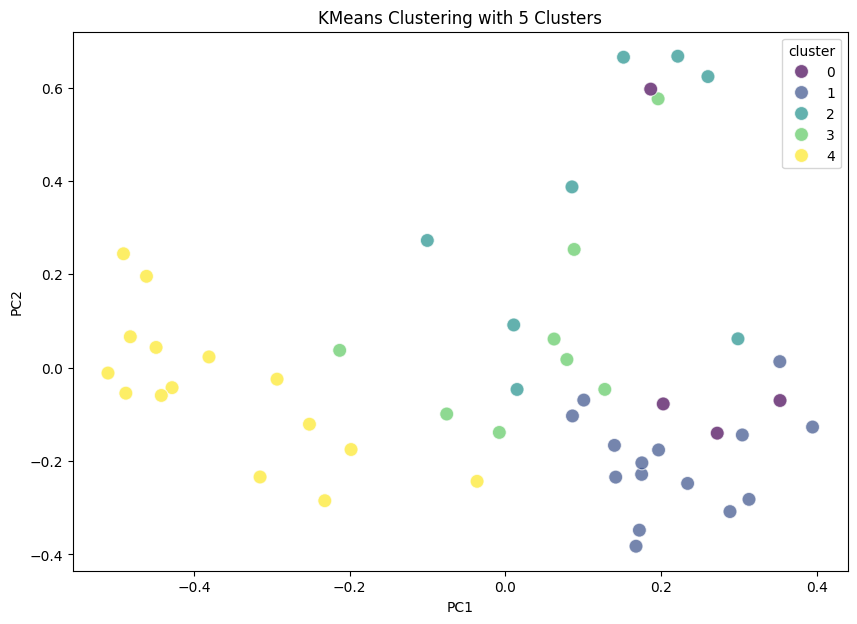


--- Texts in Cluster 0 ---
1. Learning though AI interaction
2. L��cole
3. AI integration, use of digital agents, multimodal learning analytics
4. There is trend to include more and more multimodal learning analytics to model interaction- and regulation processes. I can imagine that this trend continues

--- Texts in Cluster 1 ---
1. I believe collaboration with AI will dominate the field.
2. With the advent of AI, I am afraid that the social interactions that are the basis of collaborative learning will be limited to interactions with different artificial intelligences.
3. Artificial intelligence must be seen as a collaborative tool and not an information tool. Having say that, it will transform our relations and the way we collaborate, for all the productivist system, and so also for education purpose.
4. It will be more common and popular pedagogical approach in several fields such as instructional technoloy, learning sciences, human performance technology etc.
5. it is difficult t

interactive(children=(IntSlider(value=5, description='n_clusters', max=15, min=-5), Output()), _dom_classes=('…

In [14]:
s = 'here do you see CSCL heading toward in the future?'

# Call the function with silhouette analysis
analyze_text_clusters_with_silhouette(df, s, max_clusters=20)

Cluster 0:
This cluster focuses on integrating AI into learning, with a particular interest in AI's role as a collaborative agent within educational contexts. Discussions highlight trends like multimodal learning analytics and digital agents, which are expected to deepen insights into interaction and regulation processes.

Cluster 1:
Explores the future of collaboration with AI, expressing both enthusiasm and concern. While some view AI as a beneficial collaborative tool that will reshape educational interactions, others worry about the potential reduction in human social interaction. The integration of AI into collaborative learning is seen as likely to expand across educational technology and pedagogical models.

Cluster 2:
Presents mixed views on the future direction and inclusivity of CSCL as a field. Concerns include the need for a unified vision, challenges with gatekeeping, and the hope for greater inclusivity of diverse perspectives. The importance of supporting innovation, diversity, and large-scale, quantitative studies in CSCL is also mentioned.

Cluster 3:
Emphasizes broadening the scope of CSCL to include various emerging technologies beyond computers. Discussions include the integration of VR, mixed reality, and sociocultural considerations, along with evolving definitions to encompass a more agentic role for technology while maintaining human-human interaction as central.

Cluster 4:
Focuses on the anticipated evolution of CSCL driven by advancements in technology. The field is expected to incorporate AI, VR, AR, and big data, moving beyond traditional computer-supported settings. Ideas about rebranding CSCL to reflect evolving tools and technologies are proposed, along with the belief that CSCL will play a vital role in future educational models. Concerns about inclusivity and community openness also appear here.

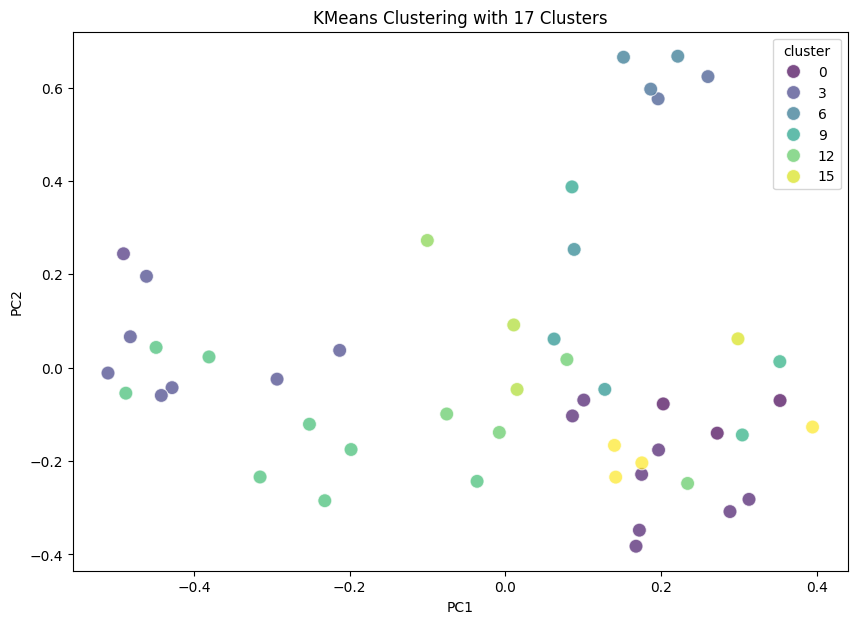


--- Texts in Cluster 0 ---
1. Learning though AI interaction
2. AI integration, use of digital agents, multimodal learning analytics
3. There is trend to include more and more multimodal learning analytics to model interaction- and regulation processes. I can imagine that this trend continues

--- Texts in Cluster 1 ---
1. I believe collaboration with AI will dominate the field.
2. With the advent of AI, I am afraid that the social interactions that are the basis of collaborative learning will be limited to interactions with different artificial intelligences.
3. Artificial intelligence must be seen as a collaborative tool and not an information tool. Having say that, it will transform our relations and the way we collaborate, for all the productivist system, and so also for education purpose.
4. It will be more common and popular pedagogical approach in several fields such as instructional technoloy, learning sciences, human performance technology etc.
5. it is difficult to predict h

interactive(children=(IntSlider(value=17, description='n_clusters', max=51, min=-17), Output()), _dom_classes=…

In [15]:
s = 'here do you see CSCL heading toward in the future?'

# Call the function with silhouette analysis
analyze_text_clusters_with_silhouette(df, s, max_clusters=20)

Cluster 0:
Explores AI’s role in learning, with a focus on AI integration and multimodal learning analytics to model interactions and regulatory processes. These tools are viewed as increasingly central to understanding and enhancing collaborative learning.

Cluster 1:
Highlights the transformative impact of AI in collaborative learning, seen as a tool that will reshape social interactions and pedagogical approaches. Some express optimism about AI's potential to support collaboration, while others are concerned about reduced human interaction and the complexity of adapting to AI in educational contexts.

Cluster 2:
Focuses on potential advancements in CSCL, specifically improved speech and text processing capabilities to enhance collaborative learning experiences.

Cluster 3:
Discusses the future evolution of CSCL, with a focus on interdisciplinary growth and inclusivity. It anticipates the adoption of various technologies, including AI, VR, and big data, which will redefine collaboration. While some are optimistic, others note challenges such as gatekeeping and a need for a broader technological perspective in the community.

Cluster 4:
Minimal content, containing only placeholders or brief responses without substantive information.

Cluster 5:
Mentions "l’école" (school) as an isolated response, lacking additional context.

Cluster 6:
Expresses uncertainty or lack of knowledge about the field, reflecting respondents' limited familiarity with CSCL.

Cluster 7:
Hopes for a merging of definitions and finding common ground in the field, reflecting a desire for unified terminology in CSCL.

Cluster 8:
Advocates for a clearer understanding of technology’s role in CSCL, proposing the postdigital approach to explore different epistemological and theoretical contributions.

Cluster 9:
Emphasizes the need for more controlled studies with larger samples to derive quantitative insights and strengthen empirical findings in CSCL.

Cluster 10:
Discusses the importance of studying co-regulation and shared regulation in group settings, and understanding how learners regulate within collaborative groups, especially as group sizes vary.

Cluster 11:
Anticipates that CSCL will increasingly integrate AI, VR, and other technologies. The term "computer-supported" may become less relevant as these tools become more widespread across the learning sciences. The cluster also addresses the growing role of teachers and computational agents in CSCL environments.

Cluster 12:
Argues for expanding CSCL beyond traditional "computer" usage to include broader technologies like VR and mixed reality, emphasizing the need to consider sociocultural contexts, equity, and power dynamics in group learning environments.

Cluster 13:
Suggests hybrid baselines that blend CS (computer science) evaluations with learning outcomes, reflecting an interest in interdisciplinary metrics.

Cluster 14:
Highlights concerns about a lack of unified vision in CSCL and fears that exclusivity may limit long-term growth. Emphasis is placed on the need for inclusivity and diverse perspectives to sustain the field.

Cluster 15:
Focuses on strengthening diversity and supporting educational innovation, underscoring the value of inclusive learning environments.

Cluster 16:
Addresses future directions in CSCL, emphasizing asynchronous and multicultural models of collaboration, inclusive classroom settings, and opportunities for distant learners to benefit from collaborative learning